## A/B - тестирование


Внутри увидите пример как формируются результаты по аб-тестированию. Прочтите сначала его, затем приступайте к выполнению задания.

В папке присутствует файл ab_test_ensembles.csv , который содержит реальные данные ab теста. Вам необходимо провести стандартный пайплайн, начав с ознакомления данных до вывода отчета. Условие гипотезы такое же как и в примере, нам необходимо нашим новым вариантом увеличить коэффициент конверсии на 2%, коэффициенты конверсии одинаковы с файлом из примера (плюс/минус) поэтому с этим проблем быть не должно. Условия гипотез теже.

В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.

Ответьте на 2 вопроса:

1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
2. Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

Также необходимо провести небольшое EDA по представленному датасету, нарисовать два графика на ваш вкус.

---

**Баллы могут быть снижены** за качество кода - старайтесь чтобы код был максимально лаконичным. Названия переменных (если они используются) должны отражать максимальную ее сущность.

**Комментарии по сдаче практического задания**:
1. Залить в репу на github в папку module_2/ab_test_inference
2. Ссылку на репо отправлять мне на почту alexadevv@gmail.com не позднее дедлайна.
3. Тема письма: Домашнее задание по модулю 2 <Фамилия Имя>
4. После дедлайна, неотправленные на почту задания, оцениваются максимум в 7 баллов.

In [43]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('ab_test_ensembles.csv')
df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [45]:
df.describe(include='all')

,user_id,timestamp,group,variants,converted,location,age_group,user_type
count,294478,294478,294478,294478,294478.000000,294478,294478,294478
unique,294478,294478,2,2,NaN,1,6,2
top,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,treatment,standard,NaN,United Kingdom,26-33,registered_user
freq,1,1,147276,147239,NaN,294478,49270,147240
mean,NaN,NaN,NaN,NaN,0.119659,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,0.324563,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN


In [46]:
df[['variants', 'user_type']].value_counts()

variants             user_type      
svm_ensemble_v_1_22  registered_user    73798
standard             new_user           73797
                     registered_user    73442
svm_ensemble_v_1_22  new_user           73441
Name: count, dtype: int64

In [47]:
df['converted'].mean()

np.float64(0.11965919355605512)

In [48]:
df.isna().mean(), df.duplicated().mean()

(user_id      0.0
 timestamp    0.0
 group        0.0
 variants     0.0
 converted    0.0
 location     0.0
 age_group    0.0
 user_type    0.0
 dtype: float64,
 np.float64(0.0))

In [49]:
valid_variants = ['standard', 'svm_ensemble_v_1_22']
df = df[df['variants'].isin(valid_variants)]
df['variants'].value_counts(normalize=True)

variants
standard               0.5
svm_ensemble_v_1_22    0.5
Name: proportion, dtype: float64

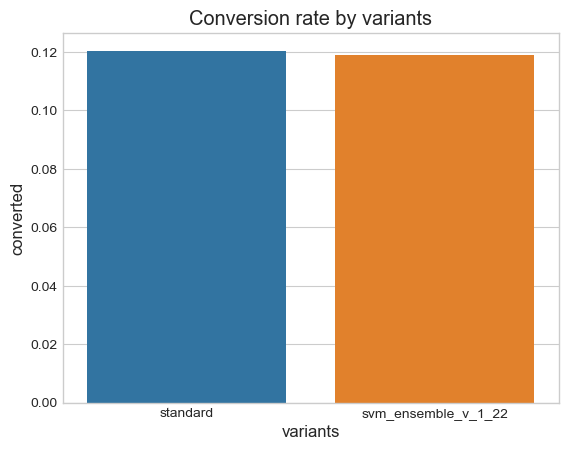

In [53]:
# Конверсия по вариантам
cr_by_variant = (
    df.groupby('variants')['converted']
      .mean()
      .reset_index()
)

sns.barplot(
    data=cr_by_variant,
    x='variants',
    y='converted',
    hue='variants',          
    palette=['#1f77b4', '#ff7f0e'],
    legend=False   
)
plt.title('Conversion rate by variants')
plt.show()

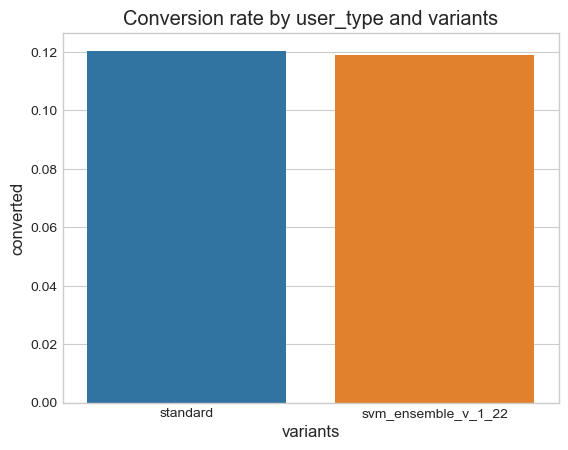

In [54]:
# Конверсия по типу пользователя и варианту
cr_user_variant = (
    df.groupby(['user_type', 'variants'])['converted']
      .mean()
      .reset_index()
)

sns.barplot(
    data=cr_by_variant,
    x='variants',
    y='converted',
    hue='variants',          
    palette=['#1f77b4', '#ff7f0e'],
    legend=False   
)
plt.title('Conversion rate by user_type and variants')
plt.show()

In [59]:
conv_std = df.loc[df['variants'] == 'standard', 'converted']
conv_svm = df.loc[df['variants'] == 'svm_ensemble_v_1_22', 'converted']

successes = np.array([conv_std.sum(), conv_svm.sum()])
nobs      = np.array([conv_std.shape[0], conv_svm.shape[0]])

z_stat, p_val = sms.proportions_ztest(successes, nobs, alternative='two-sided')

cr_std = conv_std.mean()
cr_svm = conv_svm.mean()
diff = cr_svm - cr_std

se = np.sqrt(
    cr_std * (1 - cr_std) / nobs[0] +
    cr_svm * (1 - cr_svm) / nobs[1]
)
z_crit = stats.norm.ppf(1 - 0.05 / 2)
ci_low, ci_high = diff - z_crit * se, diff + z_crit * se

results = {
    'cr_std': cr_std,
    'cr_svm': cr_svm,
    'diff': diff,
    'ci_low': ci_low,
    'ci_high': ci_high,
    'p_val': p_val
}

summary = pd.Series(results, name='value')
print(summary)

cr_std     0.120478
cr_svm     0.118841
diff      -0.001637
ci_low    -0.003981
ci_high    0.000708
p_val      0.171208
Name: value, dtype: float64


На основании результатов A/B‑теста:

- Наблюдаемая разница в конверсии между вариантами составляет: diff = -0.0016, то есть конверсия варианта `svm_ensemble_v_1_22` немного ниже, чем у `standard`.
- Доверительный интервал для разницы: ci_low = -0.003981, ci_high = 0.000708 пересекает ноль, а p_val = 0.171 > 0.05, поэтому статистически значимого эффекта не обнаружено.
- Требуемое целевое улучшение составляет +0.02 (2 п.п.), тогда как фактическая разница diff = -0.0016 не только существенно меньше этого порога по модулю, но и имеет отрицательный знак.

**Вывод:** по результатам теста нет статистически значимого улучшения конверсии варианта `svm_ensemble_v_1_22` по сравнению со `standard`, а наблюдаемая разница даже уходит в минус. При текущих данных оснований менять вариант `standard` на `svm_ensemble_v_1_22` нет. 

In [66]:
# Тесты по сегментам user_type
results = []

for utype in df['user_type'].unique():
    df_seg = df[df['user_type'] == utype]

    conv_std = df_seg.loc[df_seg['variants'] == 'standard', 'converted']
    conv_svm = df_seg.loc[df_seg['variants'] == 'svm_ensemble_v_1_22', 'converted']

    successes = np.array([conv_std.sum(), conv_svm.sum()])
    nobs      = np.array([conv_std.shape[0], conv_svm.shape[0]])

    z_stat, p_val = sms.proportions_ztest(successes, nobs, alternative='two-sided')

    cr_std = conv_std.mean()
    cr_svm = conv_svm.mean()
    diff = cr_svm - cr_std

    se = np.sqrt(
        cr_std * (1 - cr_std) / nobs[0] +
        cr_svm * (1 - cr_svm) / nobs[1]
    )
    z_crit = stats.norm.ppf(1 - 0.05 / 2)
    ci_low, ci_high = diff - z_crit * se, diff + z_crit * se

    results.append({
        'user_type': utype,
        'cr_std': cr_std,
        'cr_svm': cr_svm,
        'diff': diff,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'p_value': p_val,
        'n_std': nobs[0],
        'n_svm': nobs[1],
    })

seg_results = pd.DataFrame(results)
seg_results

,user_type,cr_std,cr_svm,diff,ci_low,ci_high,p_value,n_std,n_svm
0,registered_user,0.119877,0.120450,0.000574,-0.002748,0.003895,0.735060,73442,73798
1,new_user,0.121075,0.117223,-0.003852,-0.007161,-0.000543,0.022536,73797,73441


На основании результатов A/B‑теста по сегментам пользователей:

- Для сегмента `registered_user` наблюдаемая разница в конверсии составляет diff ≈ 0.000574 (чуть выше у `svm_ensemble_v_1_22`), доверительный интервал для diff лежит от -0.002748 до 0.003895 и включает 0, p_value ≈ 0.735060 > 0.05. Статистически значимого отличия между вариантами нет, улучшение не подтверждено, поэтому для зарегистрированных пользователей разумно оставить вариант `standard` как базовый.

- Для сегмента `new_user` наблюдаемая разница в конверсии составляет diff ≈ -0.003852 (вариант `svm_ensemble_v_1_22` показывает немного более низкую конверсию, чем `standard`), доверительный интервал от -0.007161 до -0.000543 целиком лежит в отрицательной области, а p_value ≈ 0.022536 < 0.05. Для новых пользователей есть статистически значимое ухудшение при использовании `svm_ensemble_v_1_22`, поэтому для этого сегмента нужно оставлять только вариант `standard` и не включать `svm_ensemble_v_1_22`.